In [1]:
import os
import sys

# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import text_recognizer.data

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### IAM Paragraphs dataset

In [3]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
xs, ys = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.prepare_data: Cropping IAM paragraph regions and saving them along with labels...


586MB [02:15, 4.53MB/s]                               


Computing SHA-256...
Extracting IAM data


IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0244), tensor(0.0789), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

<S>She will, in fact, be surprised at what peace
of mind ensues. (b) Concentrate on one
thing at a time. A list or a plan enables us to
put all our energies into the particular
matter on hand.<E>


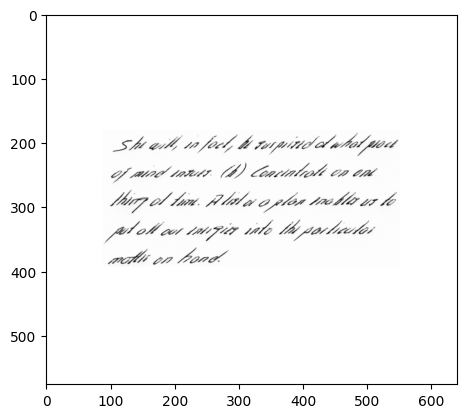

In [5]:
import random

import numpy as np
import matplotlib.pyplot as plt

def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(xs))

print(show(ys[idx]))
plt.imshow(xs[idx].view(576, 640), cmap='Greys')

### ResNet Transformer

In [ ]:
import text_recognizer.models


rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())